In [1]:
import pandas as pd
import re
import tldextract
import spacy
import nbprogress
import matplotlib.pyplot as plt
import nltk
import seaborn as sns

from wordcloud import WordCloud
from tqdm import tqdm, tqdm_notebook
from stop_words import get_stop_words
from nltk.tokenize import word_tokenize

In [2]:
# Import webscraped data
df = pd.read_json (r'data/webscraped_cleaned_2020-04-19-131331.json')
df = df[['title', 'body', 'sources', 'true_false']].reset_index(drop=True)
df.head(5)

,title,body,sources,true_false
0,Un prêtre agressé à Avignon:,"action citoyenne, sécurité et citoyenneté Prêt...",https://www.over-blog.com/cookies,FAUX
1,Francaisdefrance's Blog12/12/2016,"Soyons solidaire de notre Église, A diffuser, ...",https://subscribe.wordpress.com/,FAUX
2,Des militants dénoncent l’omerta des médias su...,Consulterle journal Sur les sites de vente en ...,https://lemonde.fr/confidentialite/,VRAI
3,Macron veut faire payer un loyer aux propriéta...,BuzzBeed Site à vocation parodique (dans la me...,https://www.buzzbeed.com/sabonner,FAUX
4,Macron a-t-il déclaré vouloir faire payer un l...,First Draft and \nGoogle News Lab Travailler e...,https://firstdraftnews.com,VRAI


In [3]:
# Sources cleaning
df['sources'] = df['sources'].apply(lambda url: tldextract.extract(url).domain)

In [4]:
# Title cleaning
df['title_clean'] = df['title'].str.lower()                                   #Converts strings to lowercase
df['title_clean'] = df['title_clean'].str.replace(r'[\%]', ' pourcents')      #Converts the % to "percents"
df['title_clean'] = df['title_clean'].str.replace(r'http[s]?\S+', ' ')        #Removes URLs
df['title_clean'] = df['title_clean'].str.replace(r'[^ \w+0-9]', ' ')         #Removes all special characters
df['title_clean'] = df['title_clean'].str.replace(r'^.\d{1}|\W\d{1}\W', ' ')  #Removes digits isolated with whitespaces
df['title_clean'] = df['title_clean'].str.replace(r' +', ' ')                 #Replaces 2+ whitespaces with single whitespace
df['title_clean'] = df['title_clean'].str.strip()                             #Removes whitespaces and newlines at the beginning/end of strings
df.drop('title', axis=1, inplace=True)
df.head(5)

,body,sources,true_false,title_clean
0,"action citoyenne, sécurité et citoyenneté Prêt...",over-blog,FAUX,un prêtre agressé à avignon
1,"Soyons solidaire de notre Église, A diffuser, ...",wordpress,FAUX,francaisdefrance s blog12 12 2016
2,Consulterle journal Sur les sites de vente en ...,lemonde,VRAI,des militants dénoncent l omerta des médias su...
3,BuzzBeed Site à vocation parodique (dans la me...,buzzbeed,FAUX,macron veut faire payer un loyer aux propriéta...
4,First Draft and \nGoogle News Lab Travailler e...,firstdraftnews,VRAI,macron a t il déclaré vouloir faire payer un l...


In [5]:
# Body cleaning
df['body_clean'] = df['body'].str.lower()                                   #Converts strings to lowercase
df['body_clean'] = df['body_clean'].str.replace(r'[\%]', ' pourcents')      #Converts the % to "percents"
df['body_clean'] = df['body_clean'].str.replace(r'http[s]?\S+', ' ')        #Removes URLs
df['body_clean'] = df['body_clean'].str.replace(r'[^ \w+0-9]', ' ')         #Removes all special characters
df['body_clean'] = df['body_clean'].str.replace(r'^.\d{1}|\W\d{1}\W', ' ')  #Removes digits isolated with whitespaces
df['body_clean'] = df['body_clean'].str.replace(r' +', ' ')                 #Replaces 2+ whitespaces with single whitespace
df['body_clean'] = df['body_clean'].str.strip()                             #Removes whitespaces and newlines at the beginning/end of strings
df.drop('body', axis=1, inplace=True)
df.head(5)

,sources,true_false,title_clean,body_clean
0,over-blog,FAUX,un prêtre agressé à avignon,action citoyenne sécurité et citoyenneté prêtr...
1,wordpress,FAUX,francaisdefrance s blog12 12 2016,soyons solidaire de notre église a diffuser il...
2,lemonde,VRAI,des militants dénoncent l omerta des médias su...,consulterle journal sur les sites de vente en ...
3,buzzbeed,FAUX,macron veut faire payer un loyer aux propriéta...,buzzbeed site à vocation parodique dans la mes...
4,firstdraftnews,VRAI,macron a t il déclaré vouloir faire payer un l...,first draft and google news lab travailler ens...


In [6]:
# Then, we concatenate all the text columns in a single column and make the dataframe tidy
df['text'] =  df[['title_clean', 'body_clean', 'sources']].agg(' '.join, axis=1)
df.drop(['title_clean', 'body_clean', 'sources'], axis=1, inplace=True)
df = df[df.columns[[1, 0]]]
df.head(5)

,text,true_false
0,un prêtre agressé à avignon action citoyenne s...,FAUX
1,francaisdefrance s blog12 12 2016 soyons solid...,FAUX
2,des militants dénoncent l omerta des médias su...,VRAI
3,macron veut faire payer un loyer aux propriéta...,FAUX
4,macron a t il déclaré vouloir faire payer un l...,VRAI


In [7]:
# Here, we lemmatize the text
nlp = spacy.load("fr_core_news_sm", disable = "ner")

# Increase nlp memory
nlp.max_length = 2000000

# Instantiate tqdm
tqdm.pandas(tqdm_notebook)

# First, we apply the text processing unit on the text
df['lemmatized'] = df['text'].progress_map(lambda x: nlp(x))

# Then we retrieve the lemmas and concatenate the words back into sentences
df['lemmas'] = df['lemmatized'].apply(lambda x : " ".join([token.lemma_ for token in x]))
df.drop(['lemmatized', 'text'], axis=1, inplace=True)

# The resulting dataframe was saved to the temp_lemmas.json file

C:\Users\edaveau\AppData\Local\Continuum\anaconda3\lib\site-packages\tqdm\std.py:666: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1856/1856 [08:49<00:00,  3.51it/s]


In [6]:
#df = pd.read_json (r'data/temp_lemmas.json')

# Instantiate tqdm
tqdm.pandas(tqdm_notebook)

# Import the stopwords from the stop_words package
stop_words_pack = get_stop_words('fr')

# Prepare a list of words we'll remove from the aforementioned stopwords
to_remove = ['aucun', 'autre','bon', 'comment', 'dedans', 'dehors', 'droite', 'début', 'encore', 'force',
             'haut','hors', 'ici', 'juste', 'maintenant', 'moins', 'nom', 'nouveau', 'nouveaux', 'personne',
             'personnes','plupart', 'pourquoi', 'quand', 'que', 'quel', 'quelle', 'quelles', 'quels', 'qui',
             'sans', 'seulement', 'tandis', 'tellement', 'valeur', 'être'] 

# Remove these words from the list
stopWords = list(set(stop_words_pack)-set(to_remove))

# The stopwords can more easily be removed if we tokenize them
df["token"] = df.apply(lambda row: word_tokenize(row['lemmas']), axis=1)

# Then we keep a list of all the words not in the stopwords list
df["stop"] = df["token"].progress_map(lambda x: [word for word in x if word not in stopWords])

# We join everything back into sentences
df["text"] = df["stop"].progress_map(lambda x: " ".join(x))
df.drop(['lemmas', 'token', 'stop'], axis=1, inplace=True)
df.head(5)

df.to_json('data/lemmas.json')

100%|██████████| 1856/1856 [00:00<00:00, 14098.25it/s]


In [12]:
df_length = pd.read_json (r'data/lemmas.json')

df_length['tokens'] = df_length['text'].apply(word_tokenize)
df_length['length'] = df_length['tokens'].apply(len)
df_length = df_length.sort_values('length', ascending = False).reset_index()

(0, 20000)

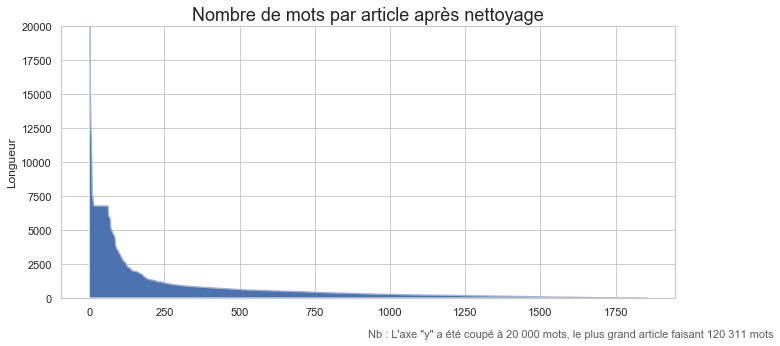

In [36]:
sns.set(style = 'whitegrid')

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize = (11, 5))

# Plot the information sources
sns.set_color_codes('muted')
sns.lineplot(x = df_length.index.values.astype(int),
             y = df_length['length'],
             alpha=0.5).set_title('Nombre de mots par article après nettoyage', fontsize = 18)
ax.text(x=0.5, y=-0.15, s='Nb : L\'axe "y" a été coupé à 20 000 mots, le plus grand article faisant 120 311 mots', 
        fontsize=11, alpha=0.75, ha='left', va='bottom', transform=ax.transAxes)

# Add an informative axis label
ax.set(ylabel = 'Longueur',
       xlabel = '')

# Adjust graphics
plt.fill_between(df_length.index.values, df_length.length.values)
plt.ylim(0, 20000)

del(df_length)

In [42]:
# Here, we'll remove rows with a word count < 20
df_ml = pd.read_json (r'data/lemmas.json')

df_ml['tokens'] = df_ml['text'].apply(word_tokenize)
df_ml['length'] = df_ml['tokens'].apply(len)
df_ml = df_ml[df_ml['length'] >= 15]
df_ml.drop(['tokens', 'length'], axis=1, inplace=True)
df_ml = df_ml.reset_index()

df_ml.to_json('data/df_machine_learning.json')

In [45]:
df = pd.read_json (r'data/df_machine_learning.json')

df_true = df[df['true_false'] == 'VRAI']
df_false = df[df['true_false'] == 'FAUX']

def print_freq_words(df) :
    articles = df.text.str.cat(sep=' ')
    #function to split text into word
    tokens = word_tokenize(articles)
    #create a set of unique words
    vocabulary = set(tokens)
    print('Vocabulary length of all the words used in the articles:', len(vocabulary))
    #calculate each word's frequency
    frequency_dist = nltk.FreqDist(tokens)
    #order each frequency in descending order, retain the first 50 elements
    frequency_words = sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:50]
    frequency_words = ", ".join(word for word in frequency_words)
    true_count = df['true_false'].str.contains('VRAI').sum()
    
    if true_count > 0:
        print('\n50 words most commonly used in true articles:\n'+frequency_words+'\n')
        
    else :
        print('\n50 words most commonly used in false articles:\n'+frequency_words+'\n')
    
print_freq_words(df_true)
print_freq_words(df_false)

Vocabulary length of all the words used in the articles: 16745

50 words most commonly used in true articles:
être, que, qui, plus, c, s, pouvoir, autre, bien, site, france, dire, monde, faux, lire, al, celui, aller, voir, article, sans, non, falloir, jour, enfant, contre, an, personne, pourcent, français, nouveau, information, compte, savoir, vouloir, après, 2017, encore, passer, mettre, rien, seul, premier, vaccin, temps, moins, dernier, grand, publier, _

Vocabulary length of all the words used in the articles: 53206

50 words most commonly used in false articles:
être, que, qui, faux, plus, s, pouvoir, lire, c, site, explication, autre, bien, france, dire, détaillé, agir, al, article, vaccin, aller, an, celui, banque, monde, sans, information, non, voir, premier, nouveau, loi, contre, aucun, euro, pourcent, vouloir, falloir, jour, personne, moins, français, après, the, enfant, compte, détailler, savoir, mettre, politique



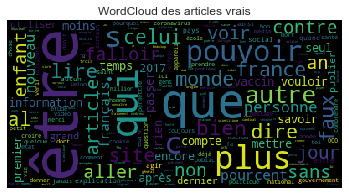

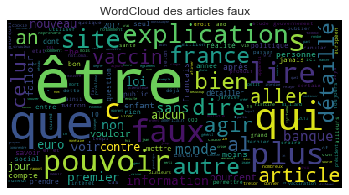

In [46]:
# Finally, we can create a WordCloud to see the words mostly used for true and false articles
def generate_wordcloud(df) :
    articles = df.text.str.cat(sep=' ')
    tokens = word_tokenize(articles)
    frequency_dist = nltk.FreqDist(tokens)
    wordcloud = WordCloud().generate_from_frequencies(frequency_dist)
    plt.imshow(wordcloud)
    true_count = df['true_false'].str.contains('VRAI').sum()
    if true_count > 0:
        plt.title('WordCloud des articles vrais')
    else :
        plt.title('WordCloud des articles faux')
    plt.axis("off")
    plt.show()
    
generate_wordcloud(df_true)
generate_wordcloud(df_false)